In [1]:
import load_files as lf
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import measurement_analysis as ma
import pickle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "/Users/blazejmanczak/Desktop/Q1/DataChallenge3/"
flow_data_DRU, level_data_DRU = lf.get_measurements(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_data/data_pump/RG8150")
rain_data = lf.get_rain(file_path +"/waterschap-aa-en-maas_sewage_2019/sewer_data/rain_timeseries")
data = lf.sdf(file_path + "waterschap-aa-en-maas_sewage_2019/sewer_model/aa-en-maas_sewer_shp")

In [3]:
# Either run this cell or open pickle in the next one
df = ma.measurement_analysis(flow_data_DRU, level_data_DRU, rain_data, area_data=data.area_data,
                             village_code="DRU", dry_threshold = 2.5)

In [21]:
"""
#Save pickle
filename = 'ma_df'
outfile = open(filename,'wb')
pickle.dump(df,outfile)
outfile.close()
"""


## Some exploration 

In [5]:
df.flow_data.set_index('TimeStamp', inplace= True, drop = False)
df.level_data.set_index('TimeStamp', inplace= True, drop = False)

In [9]:
# Only take dry days
df.level_data = df.level_data[df.level_data['Dry'] == 1]
df.flow_data = df.flow_data[df.flow_data['Dry'] == 1]

In [37]:
df.level_data["Minute"] = df.level_data["TimeStamp"].apply(lambda i: i.minute) # get the minute column
df.flow_data['Minute'] = df.flow_data['TimeStamp'].apply(lambda i: i.minute)

df.level_data["Second"] = df.level_data["TimeStamp"].apply(lambda i: i.second) # get the second column
df.flow_data['Second'] = df.flow_data['TimeStamp'].apply(lambda i: i.second)

In [465]:
df.level_data = df.level_data[df.level_data['DataQuality'] == 1]
df.flow_data = df.flow_data[df.flow_data['DataQuality'] == 1]

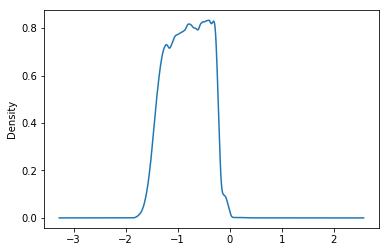

In [467]:
# Check for the  min and max "off" level - the level when the pump is not working
df.level_data['Value'].plot.kde()

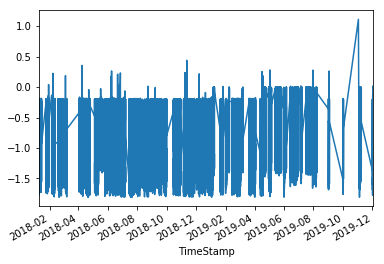

In [468]:
df.level_data['Value'].plot()

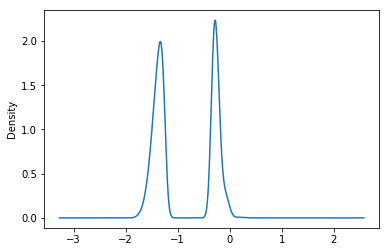

In [12]:
df.level_data[(df.level_data['Value'] < -1.25) | (df.level_data['Value'] > -0.35) ]['Value'].plot.kde()

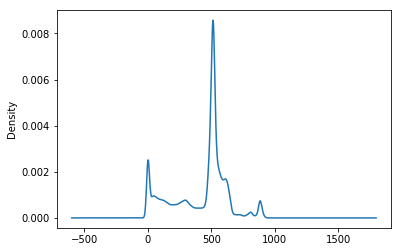

In [37]:
df.flow_data['Value'].plot.kde()

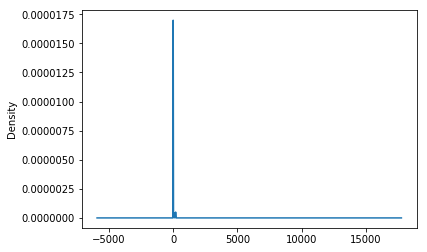

In [60]:
df.flow_data['Flow'].plot.kde()

In [38]:
df.flow_data['Value'].describe()

count    2.767759e+06
mean     4.211912e+02
std      2.187778e+02
min      0.000000e+00
25%      2.631596e+02
50%      5.072115e+02
75%      5.403768e+02
max      1.200000e+03
Name: Value, dtype: float64

## Playground for investigaring weird cases

In [470]:
def take_neigbourhood(row, minute_interval = [0,1]):
    date = row['Date'][0]
    hour = int(row['Hour'])
    minute = int(row['Minute'])
    second = int(row['Second'])
    
    lev = df.level_data[(df.level_data['Date'] == date) & (df.level_data['Hour'] == hour)
                           & (df.level_data['Minute'] <= min(minute + minute_interval[1], 59)) 
                      & (df.level_data['Minute'] >= max(minute - minute_interval[0], 0))]
    fl = df.flow_data[(df.flow_data['Date'] == date) & (df.flow_data['Hour'] == hour)
                           & (df.flow_data['Minute'] <= min(minute + minute_interval[1], 59)) 
                      & (df.flow_data['Minute'] >= max(minute - minute_interval[0], 0))]
    return lev, fl

In [471]:
low_peaks = df.level_data[((df.level_data['min']) == 1) & (df.level_data['Value'] < -1)].iloc[71:73]
low_peaks # between these times 2 peaks have been identified

RG_ID           TimeStamp     Value  DataQuality  \
TimeStamp                                                               
2018-01-10 20:19:15   8150 2018-01-10 20:19:15 -1.412076            1   
2018-01-10 20:42:55   8150 2018-01-10 20:42:55 -1.063882            1   

                           Date  Hour  Month  Weekend  TimeSpan      Freq  \
TimeStamp                                                                   
2018-01-10 20:19:15  2018-01-10    20      1        0      15.0  0.066667   
2018-01-10 20:42:55  2018-01-10    20      1        0       5.0  0.200000   

                        Delta  max  min  Dry  Minute  Second  
TimeStamp                                                     
2018-01-10 20:19:15 -0.036465    0    1    1      19      15  
2018-01-10 20:42:55 -0.336414    0    1    1      42      55

In [476]:
high_peaks = df.level_data[((df.level_data['max']) == 1) & (df.level_data['Value'] > -0.5)].iloc[73:75]
high_peaks

RG_ID           TimeStamp     Value  DataQuality  \
TimeStamp                                                               
2018-01-10 20:33:15   8150 2018-01-10 20:33:15 -0.419240            1   
2018-01-10 20:36:35   8150 2018-01-10 20:36:35 -0.255961            1   

                           Date  Hour  Month  Weekend  TimeSpan      Freq  \
TimeStamp                                                                   
2018-01-10 20:33:15  2018-01-10    20      1        0      85.0  0.011765   
2018-01-10 20:36:35  2018-01-10    20      1        0      20.0  0.050000   

                        Delta  max  min  Dry  Minute  Second  
TimeStamp                                                     
2018-01-10 20:33:15  0.051142    1    0    1      33      15  
2018-01-10 20:36:35  0.039582    1    0    1      36      35

In [479]:
lev, fl = take_neigbourhood(high_peaks.iloc[[0]], minute_interval= [3,20])
lev

RG_ID           TimeStamp     Value  DataQuality  \
TimeStamp                                                               
2018-01-10 20:30:40   8150 2018-01-10 20:30:40 -0.521822            1   
2018-01-10 20:31:45   8150 2018-01-10 20:31:45 -0.472047            1   
2018-01-10 20:31:50   8150 2018-01-10 20:31:50 -0.470382            1   
2018-01-10 20:33:15   8150 2018-01-10 20:33:15 -0.419240            1   
2018-01-10 20:33:20   8150 2018-01-10 20:33:20 -0.420904            1   
2018-01-10 20:34:00   8150 2018-01-10 20:34:00 -0.360029            1   
2018-01-10 20:35:10   8150 2018-01-10 20:35:10 -0.307091            1   
2018-01-10 20:36:35   8150 2018-01-10 20:36:35 -0.255961            1   
2018-01-10 20:37:00   8150 2018-01-10 20:37:00 -0.295544            1   
2018-01-10 20:37:05   8150 2018-01-10 20:37:05 -0.231224            1   
2018-01-10 20:38:40   8150 2018-01-10 20:38:40 -0.222976            1   
2018-01-10 20:39:45   8150 2018-01-10 20:39:45 -0.326533            1   
2018-01-10 20:40:30   8150 2018-01-10 20:40:30 -0.379474            1   
2018-01-10 20:40:55   8150 2018-01-10 20:40:55 -0.544397            1   
2018-01-10 20:41:05   8150 2018-01-10 20:41:05 -0.606904            1   
2018-01-10 20:41:50   8150 2018-01-10 20:41:50 -0.716054            1   
2018-01-10 20:42:25   8150 2018-01-10 20:42:25 -0.933624            1   
2018-01-10 20:42:40   8150 2018-01-10 20:42:40 -0.996278            1   
2018-01-10 20:42:55   8150 2018-01-10 20:42:55 -1.063882            1   
2018-01-10 20:43:15   8150 2018-01-10 20:43:15 -1.225378            1   
2018-01-10 20:43:30   8150 2018-01-10 20:43:30 -1.263643            1   
2018-01-10 20:43:35   8150 2018-01-10 20:43:35 -1.279985            1   
2018-01-10 20:43:45   8150 2018-01-10 20:43:45 -1.321200            1   
2018-01-10 20:43:50   8150 2018-01-10 20:43:50 -1.340810            1   
2018-01-10 20:44:00   8150 2018-01-10 20:44:00 -1.382058            1   
2018-01-10 20:44:05   8150 2018-01-10 20:44:05 -1.400348            1   
2018-01-10 20:44:35   8150 2018-01-10 20:44:35 -1.433335            1   
2018-01-10 20:45:40   8150 2018-01-10 20:45:40 -1.433335            1   
2018-01-10 20:45:50   8150 2018-01-10 20:45:50 -1.334763            1   
2018-01-10 20:46:10   8150 2018-01-10 20:46:10 -1.264008            1   
2018-01-10 20:46:40   8150 2018-01-10 20:46:40 -1.202822            1   
2018-01-10 20:47:00   8150 2018-01-10 20:47:00 -1.148244            1   
2018-01-10 20:47:10   8150 2018-01-10 20:47:10 -1.088858            1   
2018-01-10 20:47:35   8150 2018-01-10 20:47:35 -1.027980            1   
2018-01-10 20:48:25   8150 2018-01-10 20:48:25 -0.953763            1   
2018-01-10 20:49:35   8150 2018-01-10 20:49:35 -0.887630            1   
2018-01-10 20:50:50   8150 2018-01-10 20:50:50 -0.815225            1   
2018-01-10 20:52:20   8150 2018-01-10 20:52:20 -0.735929            1   
2018-01-10 20:52:40   8150 2018-01-10 20:52:40 -0.717919            1   
2018-01-10 20:53:20   8150 2018-01-10 20:53:20 -0.684769            1   

                           Date  Hour  Month  Weekend  TimeSpan      Freq  \
TimeStamp                                                                   
2018-01-10 20:30:40  2018-01-10    20      1        0      65.0  0.015385   
2018-01-10 20:31:45  2018-01-10    20      1        0      65.0  0.015385   
2018-01-10 20:31:50  2018-01-10    20      1        0       5.0  0.200000   
2018-01-10 20:33:15  2018-01-10    20      1        0      85.0  0.011765   
2018-01-10 20:33:20  2018-01-10    20      1        0       5.0  0.200000   
2018-01-10 20:34:00  2018-01-10    20      1        0      40.0  0.025000   
2018-01-10 20:35:10  2018-01-10    20      1        0      70.0  0.014286   
2018-01-10 20:36:35  2018-01-10    20      1        0      20.0  0.050000   
2018-01-10 20:37:00  2018-01-10    20      1        0      25.0  0.040000   
2018-01-10 20:37:05  2018-01-10    20      1        0       5.0  0.200000   
2018-01-10 20:38:40  2018-01-1

In [480]:
fl

RG_ID           TimeStamp       Value  DataQuality  \
TimeStamp                                                                 
2018-01-10 20:37:00   8150 2018-01-10 20:37:00    0.347213            1   
2018-01-10 20:38:40   8150 2018-01-10 20:38:40    0.347213            1   
2018-01-10 20:38:50   8150 2018-01-10 20:38:50  250.347200            1   
2018-01-10 20:38:55   8150 2018-01-10 20:38:55  280.347200            1   
2018-01-10 20:39:05   8150 2018-01-10 20:39:05  314.072800            1   
...                    ...                 ...         ...          ...   
2018-01-10 20:45:50   8150 2018-01-10 20:45:50    0.347213            1   
2018-01-10 20:46:05   8150 2018-01-10 20:46:05  144.170900            1   
2018-01-10 20:46:10   8150 2018-01-10 20:46:10    0.347213            1   
2018-01-10 20:48:25   8150 2018-01-10 20:48:25    0.347213            1   
2018-01-10 20:50:50   8150 2018-01-10 20:50:50    0.347213            1   

                           Date  Hour  Month  Weekend  TimeSpan      Freq  \
TimeStamp                                                                   
2018-01-10 20:37:00  2018-01-10    20      1        0      45.0  0.022222   
2018-01-10 20:38:40  2018-01-10    20      1        0      45.0  0.022222   
2018-01-10 20:38:50  2018-01-10    20      1        0      10.0  0.100000   
2018-01-10 20:38:55  2018-01-10    20      1        0       5.0  0.200000   
2018-01-10 20:39:05  2018-01-10    20      1        0       5.0  0.200000   
...                         ...   ...    ...      ...       ...       ...   
2018-01-10 20:45:50  2018-01-10    20      1        0      10.0  0.100000   
2018-01-10 20:46:05  2018-01-10    20      1        0      15.0  0.066667   
2018-01-10 20:46:10  2018-01-10    20      1        0       5.0  0.200000   
2018-01-10 20:48:25  2018-01-10    20      1        0      40.0  0.025000   
2018-01-10 20:50:50  2018-01-10    20      1        0      35.0  0.028571   

                         Flow  max  min  Dry  Minute  Second  
TimeStamp                                                     
2018-01-10 20:37:00  0.004340    0    0    1      37       0  
2018-01-10 20:38:40  0.004340    0    0    1      38      40  
2018-01-10 20:38:50  0.695409    0    0    1      38      50  
2018-01-10 20:38:55  0.389371    1    0    1      38      55  
2018-01-10 20:39:05  0.436212    0    0    1      39       5  
...                       ...  ...  ...  ...     ...     ...  
2018-01-10 20:45:50  0.000964    0    1    1      45      50  
2018-01-10 20:46:05  0.600712    1    0    1      46       5  
2018-01-10 20:46:10  0.000482    0    0    1      46      10  
2018-01-10 20:48:25  0.003858    0    0    1      48      25  
2018-01-10 20:50:50  0.003376    0    0    1      50      50  

[69 rows x 16 columns]

### Algorithm in words:
Find the local minimum of the level (the valley). Then find the next miniumum. Let the time between them be $t_{h}$.

Establish if you have a maximum of the level (the hill) between the two minimum. If not, abandon these points.
Assume that the pump works at constant flow **f** [m3/h].
Let the time between the maximum and the second of the two minima be denoted by $t_{f}$.

Then $$f \cdot t_{f}$$ tells us how much water came in time $t_{h}$.

In [485]:
high_peaks = df.level_data[((df.level_data['max']) == 1) & (df.level_data['Value'] > -0.4)]#.iloc[107:108]
low_peaks = df.level_data[((df.level_data['min']) == 1) & (df.level_data['Value'] < -1)]#.iloc[96:98]

In [486]:
high_peaks.reset_index(drop=True, inplace=True) # we want the index to be 0, 1, 2, ...
low_peaks.reset_index(drop = True, inplace=True)

high_peaks['Counter'] = range(len(high_peaks)) # useful trick for the apply function
low_peaks['Counter'] = range(len(low_peaks))

In [509]:
def find_max_in_between(time_stamp_start, time_stamp_end):
    result = high_peaks[(high_peaks['TimeStamp'] > time_stamp_start) &(high_peaks['TimeStamp'] < time_stamp_end)]
    if result.shape[0] > 1:
        print("Alert!", result.shape[0], "maximas found between:", time_stamp_start, "and", time_stamp_end)
        #print("Returning the first maxiumum...") 
        return result[result['Value'] == result['Value'].max()] # the row that has the biggest "Value"
    if result.shape[0] == 1:
        return result
    else:
        print("No maxiumum found")
        return None

def connect_the_minima(row, last_row_index):
    
    row_index = row['Counter'] # get the index of the current row
    print(row_index)
    if row_index < last_row_index:
        next_row = low_peaks.loc[row_index + 1]
        max_in_between = find_max_in_between(row['TimeStamp'], next_row['TimeStamp']) # it is a row or np.nan
        #print((max_in_between))
        if max_in_between is not None:
            tf = ((next_row['TimeStamp'] - max_in_between['TimeStamp'])).apply(lambda i: i.seconds) / 3600 #converting to hours
            return int(tf * 450) # 450 is by assumption the average flow between maxima and miniumum
        else:
            return None

    else: # the last row
        return None
    

def chain_of_the_minima(low_peaks = low_peaks):
    lp = low_peaks.copy()
    lp['SewageInflow'] =  lp.apply(lambda row: connect_the_minima(row, len(lp) - 1) , axis = 1) # in m3 between the two minimas
    return lp
    
    

In [511]:
a = chain_of_the_minima(low_peaks= low_peaks.iloc[2])
a

0
1
2
3
4
5
6
7
8
9


In [513]:
# Example of how the find_max_in_between works
find_max_in_between(low_peaks.iloc[0]['TimeStamp'], low_peaks.iloc[1]['TimeStamp'])

RG_ID           TimeStamp     Value  DataQuality        Date  Hour  Month  \
1   8150 2018-01-09 01:14:35 -0.244581            1  2018-01-09     1      1   

   Weekend  TimeSpan      Freq     Delta  max  min  Dry  Minute  Second  \
1        0     210.0  0.004762  0.050962    1    0    1      14      35   

   Counter  
1        1